In [2]:
import os
import numpy as np
from typing import Literal
from sentinelhub import CRS
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from lib.utils import load_eval_script
from lib.AOISegment import AOISegment
from sentinelhub import SentinelHubCatalog
from sentinelhub import SentinelHubRequest, DataCollection, BBox, bbox_to_dimensions, SHConfig, MimeType

In [6]:
load_dotenv()
config = SHConfig()
config.sh_client_id = os.environ.get("SENTINEL_HUB_CLIENT_ID")
config.sh_client_secret = os.environ.get("SENTINEL_HUB_CLIENT_SECRET")
catalog = SentinelHubCatalog(config=config)

In [7]:
def get_area_mask(time_stamp: str,
                  area_type: Literal["cloud", "buildup", "green", "water"],
                  bbox: BBox, config: SHConfig) -> float:
    eval_script_map = {
        "cloud": "es_clm_binary.js",
        "buildup": "es_bua_binary.js",
        "green": "es_gc_binary.js",
        "water": ""
    }
    script = eval_script_map[area_type]
    area_mask = get_img(
        eval_script=load_eval_script("eval_scripts/" + script),
        time_stamp=time_stamp,
        bbox=bbox,
        config=config)
    return area_mask


def get_img(eval_script: str, time_stamp: str, bbox: BBox, config: SHConfig) -> np.ndarray:
    """
    Gets and image from the bbox based on a time stamp and eval script
    """
    request_image = SentinelHubRequest(
        evalscript=eval_script,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_stamp,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        size=bbox_to_dimensions(bbox, resolution=10),
        config=config,
    )
    data = request_image.get_data()  # [0] is the image
    return data[0]

In [8]:
zurich = True

if zurich:
    bbox = BBox(bbox=(8.477, 47.336, 8.605, 47.417), crs=CRS.WGS84)
    time_stamp = "2025-04-23"
    image = PILImage.open("images/Zurich-2025-04-23.jpeg")
    image_np = np.array(image)

else:
    bbox = BBox(bbox=(8.629496, 47.5022965, 8.757201, 47.58301), crs=CRS.WGS84)
    time_stamp = "2024-06-19"
    image = PILImage.open("images/Winterthur-2024-06-19.jpeg")
    image_np = np.array(image)

cloud_mask = get_area_mask(time_stamp, "cloud", bbox=bbox, config=config)
buildup_mask = get_area_mask(time_stamp, "buildup", bbox=bbox, config=config)
green_mask = get_area_mask(time_stamp, "green", bbox=bbox, config=config)
# water_mask = get_area_mask(time_stamp, "water", bbox=bbox, config=config)

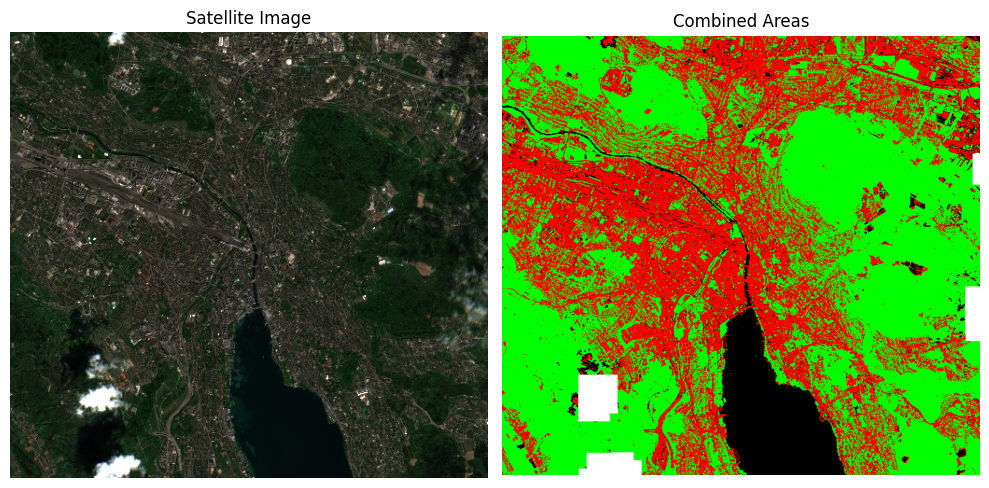

In [9]:
combined_mask = AOISegment.combine_masks(cloud_mask, buildup_mask, green_mask)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image_np)
axs[0].axis("off")  # optional
axs[0].set_title("Satellite Image")  # optional

axs[1].imshow(combined_mask)
axs[1].axis("off")
axs[1].set_title("Combined Areas")

plt.tight_layout()
plt.show()